# <span style="color:black;">Tweets</span> <span style="color:blue;">Languages</span> <span style="color:red;">Analysis</span>

### In this notebook, using tweets collected randomly from some contries(<span style="color:black;">Egypt </span>, <span style="color:blue;">France </span>, and <span style="color:red;">Turkey </span>), and Facebook's model fastText for language identification, we interpret and analyze the data in various ways. 


#### Steps take: 
1. **Setting up the environment**
2. **Loading & cleaning random twitter handles.**
2. **Scraping tweets of each handle.**
3. **Processing the tweets.**
4. **Predicting the languages of tweets**
5. **Analyzing the results.**

## 1. Setting up the environment

**Importing requried libraries**

We used:
- **Apache spark** in this project, so we import the some librarie required, **pyspark** for starting a **spark session.** 
- **plotly** for visualization.
- **fastText** for language identification.
- **twint** for scraping tweets of a user. 


In [1]:
# !pip install pycountry
# !pip install matplotlib

In [2]:
from pyspark.sql import SparkSession  
import plotly.express as px
import plotly.graph_objects as go
from pyspark.sql.types import FloatType 
import fasttext as ft 
import twint
import emoji
import ast
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display 


creating a **spark session** and a **spark context**

In [3]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

**Loading** the pretrained **model** using the method load_model from fastText

In [4]:
#loading fastText model
# lid_model = ft.load_model("lid.176.ftz") 
lid_model = ft.load_model("lid.176.bin") 

## 2. Loading & Cleaning Random Twitter Handles
**Loading** the random twitter **handles** for each country. Then eliminating the duplicates in the files.  

In [5]:
# reading the file with spark context's method textFile, the converting the rdd to a dataframe.
def readTxtToDF(textFile):
    return sc.textFile(textFile).map(lambda k: k.split(' ')).toDF(['handles'])

handles_files = {'turkey':'turkeyHandles.txt', 'egypt':'egyptHandles.txt', 'france':'franceHandles.txt'}
for country in handles_files: 
    handles = readTxtToDF(handles_files[country])
    handles_files[country] = handles
    open(f'{country}DoneHandles.txt', 'a').close() # create done file

## 3. Scraping Tweets Of Each Handle

In [6]:
# TODO get tweets for each handle 
def gethanldesTweets(username):
    tweets = []
    config = twint.Config()
    config.Username = username
    config.Hide_output = True 
    config.Limit = 50
    config.Store_object = True
    config.Store_object_tweets_list = tweets
    twint.run.Search(config)
    return tweets

## 4. Processing The Tweets

In [7]:
## TODO clean the tweets and prepare them for fastText's model
def remove_emoji(text):
    return emoji.get_emoji_regexp().sub(u'', text)

def cleanTweet(tweet):
    return remove_emoji(' '.join([word.lower() for word in tweet.split(' ') 
                            if '@' not in word and '#' not in word 
                           and 'http' not in word and 'pic.twitter.com' 
                        not in word]).replace('\n', ''))


## 5.Predicting The Languages Of Tweets

In [8]:
import nest_asyncio 
nest_asyncio.apply()
handle_langs = []
def detectLang(text):
    return lid_model.predict(text)

for country in handles_files: 
    with open(f'{country}DoneHandles.txt', 'r') as fr:
        doneHandles = set([handle.replace('\n','') for handle in fr.readlines()])
    handles_list = handles_files[country].rdd.map(lambda x: x[0]).distinct().collect()
    
    print(f'country:{country}')
    print(f'All Handles: {len(handles_list)}')
    print(f'skippedDone: {len(doneHandles)}')

    for i in range(len(handles_list)):
        handle = handles_list[i]
        if handle in doneHandles:   
            continue
        tweetObjects = gethanldesTweets(handle)
        print(f'Handles done in total: {i+1}')
        langs = []
        for tweetobj in tweetObjects:
            clean_tweet = cleanTweet(tweetobj.tweet)
            lang = detectLang(clean_tweet)
            langCode = lang[0][0].split('__')[-1]
            langAcc = lang[1][0]
            langs.append((langCode, langAcc))
        lang_tuples = sc.parallelize(langs).groupByKey().mapValues(lambda x: len(list(x))).collect()
        handle_langs.append((handle, lang_tuples))

        with open(f'{country}Results.txt', 'a') as fres:
            handle_langs_save = handle + "-" + str(lang_tuples)
            fres.write(handle_langs_save + '\n')
        with open(f'{country}DoneHandles.txt', 'a') as fa:
            fa.write(handle + '\n')

country:turkey
All Handles: 10496
skippedDone: 10496
country:egypt
All Handles: 10139
skippedDone: 10139
country:france
All Handles: 10507
skippedDone: 10507


In [9]:
# get saved handles and langs from result files 
def langCodeToName(lang):
    langName = None
    if len(lang) == 2:
        langName = pycountry.languages.get(alpha_2=lang)
    else: 
        langName = pycountry.languages.get(alpha_3=lang)
        
    if langName != None: return langName.name 
    else: return langName
dataframes = {}
for country in ['france', 'egypt', 'turkey']:
    with open(f'{country}Results.txt','r') as fres:
            lines = fres.readlines()
            handle_langs = [(line.split('-')[0], [ (langCodeToName(i[0]),
                            i[1]) for i in ast.literal_eval(line.replace('\n', '').split('-')[1])]) for line in lines]
    df = sc.parallelize(handle_langs).toDF(['handle', 'languages'])
    dataframes[country] = df

franceDf = dataframes['france']
egyptDf = dataframes['egypt']
turkeyDf = dataframes['turkey']

## 6. EXTERNAL DATASETS WE USED
###### These gather the number of applications of asylum and also the number of people accepted.

In [10]:

asylum_applicants = pd.read_csv("./External Datasets/asylum_seekers.csv")
asylum_applicants = asylum_applicants.fillna(value='')
asylum_applicants = asylum_applicants.replace(['*'], [''])
labels = ['year', 
          'country_of_residence', 
          'country_of_origin', 
          'rsd_type', 
          'total_pending_at_year_start', 
          'total_pending_year_start_UNHCR_assisted', 
          'applied_during_year',
          'decisions_recognized',
          'decisions_other', 
          'rejected',
          'otherwise_closed',
          'total_decisions',
          'total_pending_at_year_end', 
          'total_pending_year_end_UNHCR_assisted']
asylum_applicants.columns = labels
asylum_applicants['applied_during_year'] = pd.to_numeric(asylum_applicants['applied_during_year'], errors='coerce')
asylum_applicants = asylum_applicants.replace(["Syrian Arab Rep."], ["Syria"])
syrians = asylum_applicants.query("country_of_origin == 'Syria'")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.



In [11]:
resettlement = pd.read_csv("./External Datasets/time_series.csv")
labels1 = ['year', 
          'country_of_residence', 
          'country_of_origin', 
          'population_type',
          'population_count']
resettlement.columns = labels1
syrian_resettlement = resettlement.query("country_of_origin == 'Syrian Arab Rep.'")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.



## 4. Analyzing The Results

## TODO : Analyze -> emphasize a statistic -> Possible decisions  that could be made based on that static 

Must:  

    1) Languages spoken in a country -> languages centers could target countries. ASEM
    
    2) Immigrants (countries that have many immigrants will tend to have multiple languages) KHALED
    
    3) The average number of languages a person speaks in a country --> relate to how educated a country is?  DIALA
    
    4) Geographical factor and its effect on how many languages a country speaks. 
    
    5) # of languages spoken in a country --> relate to Tourism. 
    
    6) Likelyhood of 2 countries being involoved in trade if they have a language in common. NURHANDE
    
    7) History of a a country's colonization --> its affect on how many languages it speaks. ASEM

    
    
    #MAYBE:
    - How global its commerce is.


## a) Tweets' Languages

#### First, with a closer look, we see the tweets' languages in a country and their frequencies.

### <span style="color:blue;">France </span>

In [79]:
def getLangFreqs(df):
    return df.rdd.flatMap(lambda x: [(i[0], i[1]) for i in x[1] if i[1] > 5]).reduceByKey(
                        lambda x, y: x + y).sortBy(lambda x: -1 * x[1])

france_lang_freq = getLangFreqs(franceDf)

In [80]:
def plotLangFreqTable(lang_freq_rdd):
    return  go.Figure(data=[go.Table(header=dict(values=['<b>Language</b>', '<b>Frequency</b>'],
                            line_color='darkslategray', fill_color='lightskyblue'),
                     cells=dict(values=[lang_freq_rdd.keys().collect(), lang_freq_rdd.values().collect()]))])

plotLangFreqTable(france_lang_freq).show()

The table above shows the languages the their frequencies. As expected, most of the people tweet in french which is expected. However, people still tweet in many other languages. Those other languages are not here by chance. There are factors that lead poeple tweet in other languages. We examine this more when we have even a closer look at the data.

We also plotted a pie chart representing the same data to see the percentage of each language.

In [81]:
def plotPieLangFreq(lang_freq_rdd):
    return px.pie(values=lang_freq_rdd.values().collect(), names=lang_freq_rdd.keys().collect(),
                 title='')
plotPieLangFreq(france_lang_freq).show()

Similarly for Egypt and Turkey we see the native language with highest frequncy then comes some other languages. 

### <span style="color:black;">Egypt </span>

In [82]:
egypt_lang_freq = getLangFreqs(egyptDf)
plotLangFreqTable(egypt_lang_freq).show()

In [83]:
plotPieLangFreq(egypt_lang_freq).show()

### <span style="color:red;">Turkey </span>

In [84]:
turkey_lang_freq = getLangFreqs(turkeyDf)
plotLangFreqTable(turkey_lang_freq).show()

In [85]:
plotPieLangFreq(turkey_lang_freq).show()

There is something to notice here. The differences between the percentages of the native language of each country. Turkey has the highest one. This predictable since Turkish people tend to talk only in Turkish, and hence tweet in it. The case for Egypt is different. People in Egypt tend to use foreign for languages more than there native one, and hence tweet in them more. 

## b) Tweets' Languages & IMMIGRATION

### But what's something that is interesting in the last couple of charts? 
###### When you look at Turkey and France, you will easily notice how Arabic should logically be a bit more prominent since both countries have a big number of Arabic immigrants/refugees.
###### So then we decided we would see if that's actually the case. Since Syrians make the biggest number of refugees, shouldn't these countries have more Arabic tweets?

In [86]:
arabic_tweets_number_turkey = turkey_lang_freq.filter(lambda x: x[0] == 'Arabic').collect()[0][1]
arabic_tweets_number_france = france_lang_freq.filter(lambda x: x[0] == 'Arabic').collect()[0][1]
fig = px.bar(x=['Turkey', 'France'], y=[arabic_tweets_number_turkey, arabic_tweets_number_france],
             color=[arabic_tweets_number_turkey, arabic_tweets_number_france])

fig.update_layout(
    title='Number of Arabic Tweets in Turkey and France',
    yaxis=dict(title='# of Tweets'),
)

fig.show()


In [87]:
FRrefug = syrian_resettlement.query("country_of_residence == 'France'\
                and population_type == 'Refugees (incl. refugee-like situations)'")
EGrefug = syrian_resettlement.query("country_of_residence == 'Egypt'\
                    and population_type == 'Refugees (incl. refugee-like situations)'")
TRrefug = syrian_resettlement.query("country_of_residence == 'Turkey'\
                and population_type == 'Refugees (incl. refugee-like situations)'")

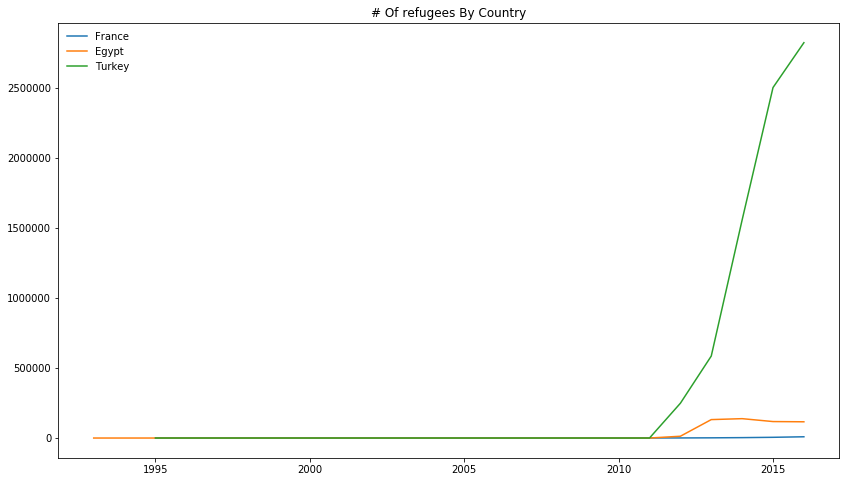

In [88]:
fig = plt.figure(figsize=(14,8))
ax = plt.axes()
plt.plot(FRrefug.year, FRrefug.population_count, label = 'France')
plt.plot(EGrefug.year, EGrefug.population_count, label = 'Egypt')
plt.plot(TRrefug.year, TRrefug.population_count, label = 'Turkey')
plt.title("# Of refugees By Country")
# plt.xlabel("Years")
# plt.ylabel="Inthousand"
ax.legend(frameon=False)

### Now this is where it makes sense:
###### The graph shows that Turkey's refugee staus holders skyrocketed, whereas in France, the number of the Arabic refugees remained somewhat small and did not really increase much because Turkey took in way more Syrians than France did and that's why Turkey has more Arabic tweets. We may reason this in a different way. The immigrants usually learn the language of the country they migrate to in order to adapt to the new society. Therefore, it is a normal thing not to see a massive number of tweets in Arabic. 

## c) Colonization & Tweets' Languages 

##### Now, it is time to reason why some countries have interest or actually were forced to have interests in some languages to tweet in. 

### <span style="color:black;"> The French and British colonization of Egypt</span>

In 1798, a French Invasion took a place in Egypt. This had a major effect on Egyptians. At some point of time, French was the primary foregin language in media and in many other sectors. <b>What is very interesting is that during the British colonization, that happened after the French invasion, French was the medium of communication between Egyptians and foreigners.</b> Later, English became the second offical language of Egypt.
<img src="Anglo-egyptian_war.jpg" />

In [89]:
fig = px.bar(x=egypt_lang_freq.keys().collect()[:4], y=egypt_lang_freq.values().collect()[:4], 
             color=egypt_lang_freq.values().collect()[:4])
fig.show()

In the above graph, French appears to be still used in Egypt. We believe that the graph would have been different if the tweets were collected years ago. French would've been in the English language's place. And we believe that this graph may change years later. 

## d) Tweets' Languages & Multilingualism

### Here, we go one level deeper to look at the users and the number of the languages they tweet in. 

We look the average number of languages a user tweets in per country. On Average, a user in Egypt or France is a quinquelingual, and a quadrilingual in Turkey. This does not make sense at all. You can't say that a person knows a language if he/she tweets in it. People may tweet in languages they can't speak with some intention. Another reason is that people sometimes write some tweets imporperly in a language that the model fails to identify that language. E.g. in Egypt, people use English alphabets to write Arabic! They call it 'Franko'. 

In [129]:
def getLangsAvgPerUser(df):
    return df.rdd.map(lambda x: len(x[1])).reduce(lambda x, y: x + y)/len(df.collect())

avgsPerCountry = [getLangsAvgPerUser(egyptDf), getLangsAvgPerUser(franceDf), getLangsAvgPerUser(turkeyDf)]
fig = px.bar(x=['Egypt', 'France', 'Turkey'], y=avgsPerCountry)
fig.update_layout(
    title='Average Number of Languages Per User In Each Country',
    yaxis=dict(title='AVG # of Languages'),
)
fig.show()


## Languages Spoken per capita and IQ of the citizens


In [113]:
def lang_spoken_per_capita(df):
    d = df.rdd.flatMap(lambda x: [(len(x[1]), 1) for i in x[1] if i[1] > 5]).reduceByKey(
    lambda x, y: x + y)
    total_num_of_people = d.values().sum()
    return d.map(lambda x: (x[1] / total_num_of_people) * x[0]).sum()

### <span style="color:red;">Turkey </span>

In [114]:
turkey_lang_per_capita = lang_spoken_per_capita(turkeyDf)
turkey_lang_per_capita

4.660764767147747

### <span style="color:blue;">France </span>

In [115]:
france_lang_per_capita = lang_spoken_per_capita(franceDf)
france_lang_per_capita

5.375868486352357

### <span style="color:black;">Egypt </span>

In [116]:
egypt_lang_per_capita = lang_spoken_per_capita(egyptDf)
egypt_lang_per_capita

6.16955835962145

In [112]:
# the IQs mentioned reference is: https://worldpopulationreview.com/countries/average-iq-by-country/  
rdd_per_capita = sc.parallelize([('turkey',turkey_lang_per_capita, '90'),('france',france_lang_per_capita, '98'),('egypt',egypt_lang_per_capita, '81')])
dataframe = rdd_per_capita.toDF().withColumnRenamed('_1', 'Country').withColumnRenamed('_2', 'Language/Capita').withColumnRenamed('_3','IQ')


In [59]:
d_p= dataframe.toPandas()
fig = go.Figure()
fig.add_trace(go.Bar(
    x=d_p['IQ'], y=d_p['Language/Capita'],marker_color='indianred'))
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()

#### The graph above shows the strong relationship between the average number of languages spoken by a person in one of the corresponding countries and the IQ for that person. In which it clearly shows how bilingualism increases one's IQ. 

In [29]:
# fig = px.bar(d_p, x='IQ', y='Language/Capita',
#              hover_data=['Country', 'IQ'], color='IQ', height=400)
# fig.show()